**Diagnosis of Diabetic Retinopathy through Machine Learning-Based Image Processing**

Kelompok 7 LK01

*   Orsino Jerrell Bruinier - 2602065540
*   Talethia Hayfa Syukur - 2602067016

In [12]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision import datasets
from torch.utils.data import DataLoader
import torch.optim as optim

In [3]:
from google.colab import drive
drive.mount('/content/drive')

data_root= '/content/drive/MyDrive/Colab Notebooks/Diabetic Retinopathy Dataset'

Mounted at /content/drive


In [14]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


train_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/Colab Notebooks/Diabetic Retinopathy Dataset/Train', transform=transform)
val_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/Colab Notebooks/Diabetic Retinopathy Dataset/Validation', transform=transform)
test_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/Colab Notebooks/Diabetic Retinopathy Dataset/Tester', transform=transform)

In [5]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [6]:
class_name = train_dataset.classes
class_name

['DR', 'No_DR']

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
num_classes =2
model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = correct / total
    val_loss /= len(val_loader.dataset)

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {epoch_loss:.4f}, '
          f'Val Loss: {val_loss:.4f}, '
          f'Val Acc: {val_accuracy:.4f}')

model.eval()
test_correct = 0
test_total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = test_correct / test_total
print(f'Test Accuracy: {test_accuracy:.4f}')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 186MB/s]


Epoch [1/10], Train Loss: 0.2708, Val Loss: 0.2376, Val Acc: 0.9360
Epoch [2/10], Train Loss: 0.1372, Val Loss: 0.1859, Val Acc: 0.9322
Epoch [3/10], Train Loss: 0.1308, Val Loss: 0.1729, Val Acc: 0.9492
Epoch [4/10], Train Loss: 0.1186, Val Loss: 0.1162, Val Acc: 0.9605
Epoch [5/10], Train Loss: 0.1055, Val Loss: 0.2185, Val Acc: 0.9303
Epoch [6/10], Train Loss: 0.0969, Val Loss: 0.1158, Val Acc: 0.9623
Epoch [7/10], Train Loss: 0.0832, Val Loss: 0.1385, Val Acc: 0.9586
Epoch [8/10], Train Loss: 0.0657, Val Loss: 0.1238, Val Acc: 0.9623
Epoch [9/10], Train Loss: 0.0764, Val Loss: 0.1596, Val Acc: 0.9454
Epoch [10/10], Train Loss: 0.0540, Val Loss: 0.1141, Val Acc: 0.9661
Test Accuracy: 0.9610


In [9]:
predicted

tensor([0, 0, 1, 1, 0, 0, 1], device='cuda:0')

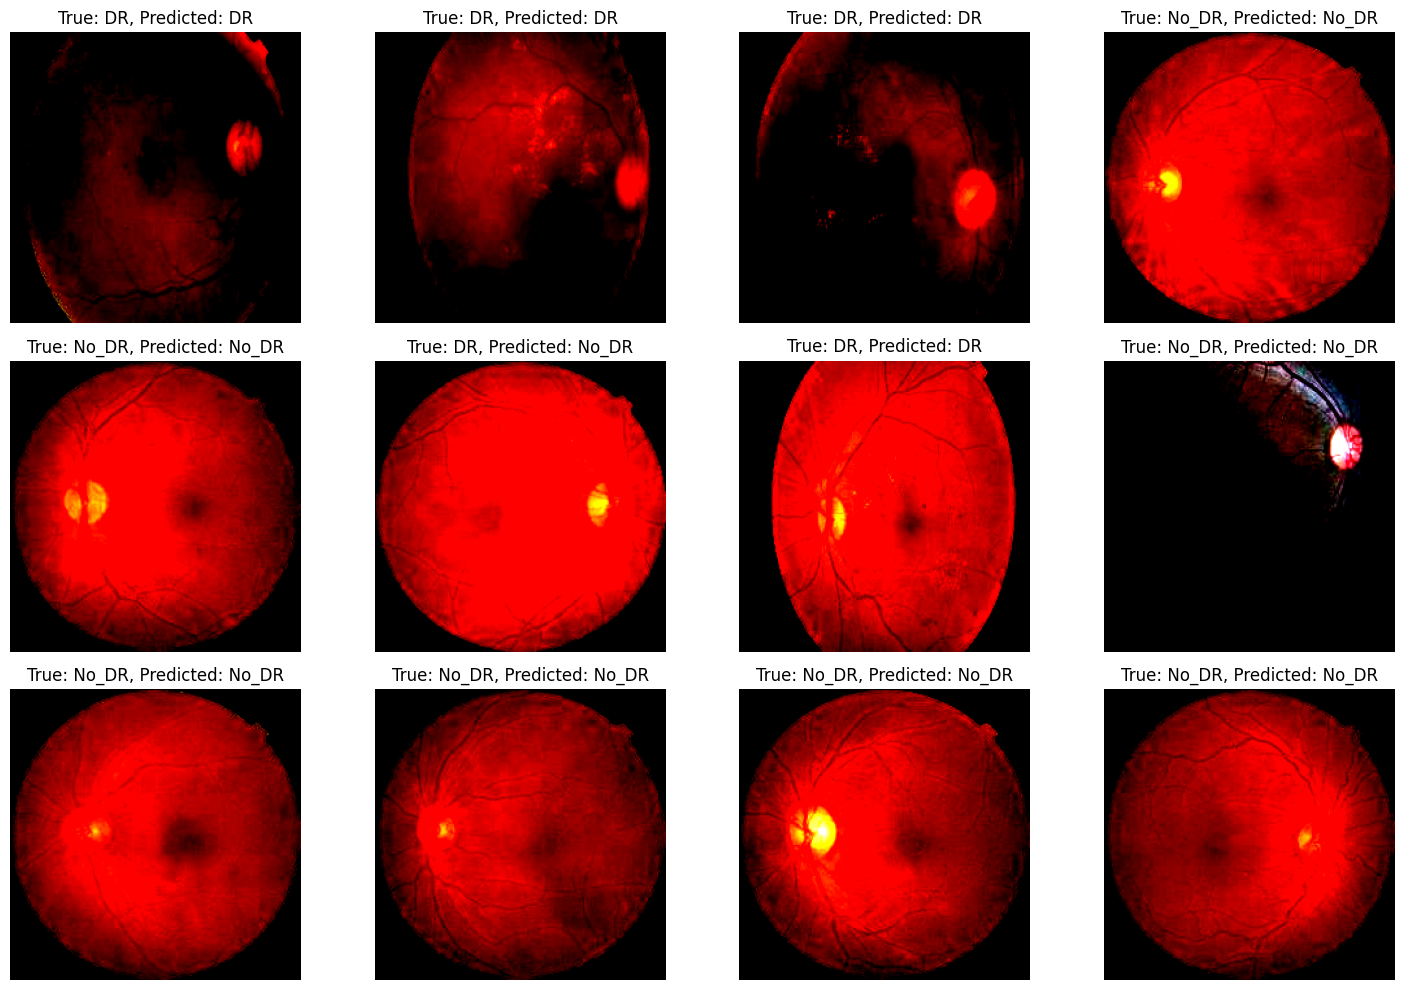

In [15]:
import matplotlib.pyplot as plt
import numpy as np

batch_size = 32

model.eval()

images, labels = next(iter(test_loader))

images, labels = images.to(device), labels.to(device)

outputs = model(images)

_, predicted = torch.max(outputs, 1)

images = images.cpu().numpy()

predicted_np = predicted.cpu().numpy()

true_labels_np = labels.cpu().numpy()

num_samples_to_show = 12

indices = np.random.choice(batch_size, num_samples_to_show, replace=False)

fig, axes = plt.subplots(3, 4, figsize=(15, 10))

for i, idx in enumerate(indices):
    ax = axes[i // 4, i % 4]
    ax.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(f'True: {class_name[true_labels_np[idx]]}, Predicted: {class_name[predicted_np[idx]]}')
    ax.axis('off')

for i in range(num_samples_to_show, 12):
    axes[i // 4, i % 4].axis('off')

plt.tight_layout()
plt.show()

Test Accuracy: 0.9610


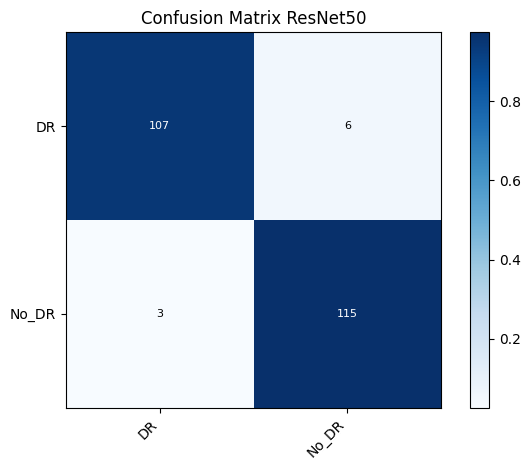

In [16]:
model.eval()
test_correct = 0
test_total = 0
all_predicted = []
all_true = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

        all_predicted.extend(predicted.cpu().numpy())
        all_true.extend(labels.cpu().numpy())

test_accuracy = test_correct / test_total
print(f'Test Accuracy: {test_accuracy:.4f}')

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(all_true, all_predicted)

cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots()
im = ax.imshow(cm_norm, cmap='Blues')

classes = class_name
ax.set_xticks(np.arange(len(classes)))
ax.set_yticks(np.arange(len(classes)))
ax.set_xticklabels(classes, rotation=45, ha='right')
ax.set_yticklabels(classes)
ax.set_title('Confusion Matrix ResNet50')

fmt = 'd'
thresh = cm_norm.max() / 2.
for i in range(len(classes)):
    for j in range(len(classes)):
        ax.text(j, i, format(cm[i, j], fmt), ha='center', va='center',
             fontsize=8, color='white' if cm_norm[i, j] > thresh else 'black')

fig.colorbar(im)
plt.tight_layout()
plt.show()

In [18]:
model.eval()
test_correct = 0
test_total = 0
all_predicted = []
all_true = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

        all_predicted.extend(predicted.cpu().numpy())
        all_true.extend(labels.cpu().numpy())

test_accuracy = test_correct / test_total
print(f'Test Accuracy: {test_accuracy:.4f}')

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(all_true, all_predicted)

tn, fp, fn, tp = cm.ravel()

sensitivity = tp / (tp + fn)

specificity = tn / (tn + fp)

print('Confusion Matrix ResNet50:')
print(cm)
print(f'Test Accuracy: {test_accuracy:.7f}')
print(f'Sensitivity (Recall): {sensitivity:.7f}')
print(f'Specificity: {specificity:.7f}')

Test Accuracy: 0.9610
Confusion Matrix ResNet50:
[[107   6]
 [  3 115]]
Test Accuracy: 0.9610390
Sensitivity (Recall): 0.9745763
Specificity: 0.9469027
